<a href="https://colab.research.google.com/github/robinsantos-hue/CSCI167/blob/main/10_5_Convolution_For_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 10.5: Convolution for MNIST**

This notebook builds a proper network for 2D convolution.  It works with the MNIST dataset (figure 15.15a), which was the original classic dataset for classifying images.  The network will take a 28x28 grayscale image and classify it into one of 10 classes representing a digit.

The code is adapted from https://nextjournal.com/gkoehler/pytorch-mnist

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

In [3]:
# Run this once to load the train and test data straight into a dataloader class
# that will provide the batches
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.66MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.19MB/s]


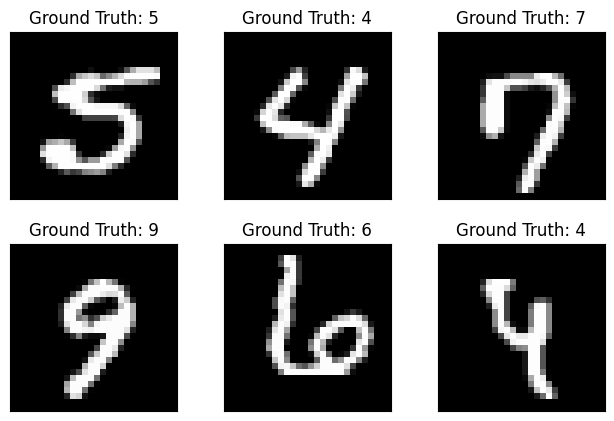

In [4]:
# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

Define the network.  This is a more typical way to define a network than the sequential structure.  We define a class for the network, and define the parameters in the constructor.  Then we use a function called forward to actually run the network.  It's easy to see how you might use residual connections in this format.

In [5]:
from os import X_OK
# TODO Change this class to implement
# 1. A valid convolution with kernel size 5, 1 input channel and 10 output channels
# 2. A max pooling operation over a 2x2 area
# 3. A Relu
# 4. A valid convolution with kernel size 5, 10 input channels and 20 output channels
# 5. A 2D Dropout layer
# 6. A max pooling operation over a 2x2 area
# 7. A relu
# 8. A flattening operation
# 9. A fully connected layer mapping from (whatever dimensions we are at-- find out using .shape) to 50
# 10. A ReLU
# 11. A fully connected layer mapping from 50 to 10 dimensions
# 12. A softmax function.

# Replace this class which implements a minimal network (which still does okay)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1. Valid convolution, 1 channel in, 10 channels out, stride 1, kernel size = 5
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # 2. Max pooling over a 2x2 area
        self.pool1 = nn.MaxPool2d(2)
        # 3. ReLU
        self.relu1 = nn.ReLU()
        # 4. Valid convolution, 10 channels in, 20 channels out, stride 1, kernel size = 5
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # 5. 2D Dropout layer
        self.drop = nn.Dropout2d()
        # 6. Max pooling over a 2x2 area
        self.pool2 = nn.MaxPool2d(2)
        # 7. ReLU
        self.relu2 = nn.ReLU()
        # 8. Flattening operation
        self.flatten = nn.Flatten()
        # Calculate input size for fully connected layer
        self.fc_input_size = 20 * 4 * 4  # Adjust the dimensions based on the output of the previous layers
        # 9. Fully connected layer mapping to 50
        self.fc1 = nn.Linear(self.fc_input_size, 50)
        # 10. ReLU
        self.relu3 = nn.ReLU()
        # 11. Fully connected layer mapping to 10
        self.fc2 = nn.Linear(50, 10)
        # 12. Softmax
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.drop(x)
        x = self.pool2(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x






In [6]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [7]:
# Create network
model = Net()
# Initialize model weights
model.apply(weights_init)
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [8]:
# Main training routine
def train(epoch):
  model.train()
  # Get each
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    # Store results
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

In [9]:
# Run on test data
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [10]:
# Get initial performance
test()
# Train for three epochs
n_epochs = 3
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.12/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: -0.1024, Accuracy: 976/10000 (10%)

Train Epoch: 1 [0/60000]	Loss: -0.105756
Train Epoch: 1 [640/60000]	Loss: -0.107728
Train Epoch: 1 [1280/60000]	Loss: -0.109982
Train Epoch: 1 [1920/60000]	Loss: -0.133962
Train Epoch: 1 [2560/60000]	Loss: -0.128783
Train Epoch: 1 [3200/60000]	Loss: -0.111450
Train Epoch: 1 [3840/60000]	Loss: -0.134672
Train Epoch: 1 [4480/60000]	Loss: -0.115491
Train Epoch: 1 [5120/60000]	Loss: -0.156025
Train Epoch: 1 [5760/60000]	Loss: -0.166906
Train Epoch: 1 [6400/60000]	Loss: -0.088498
Train Epoch: 1 [7040/60000]	Loss: -0.151045
Train Epoch: 1 [7680/60000]	Loss: -0.173654
Train Epoch: 1 [8320/60000]	Loss: -0.171391
Train Epoch: 1 [8960/60000]	Loss: -0.199187
Train Epoch: 1 [9600/60000]	Loss: -0.204556
Train Epoch: 1 [10240/60000]	Loss: -0.194520
Train Epoch: 1 [10880/60000]	Loss: -0.159459
Train Epoch: 1 [11520/60000]	Loss: -0.222696
Train Epoch: 1 [12160/60000]	Loss: -0.249293
Train Epoch: 1 [12800/60000]	Loss: -0.259030
Train Epoch: 1 [1

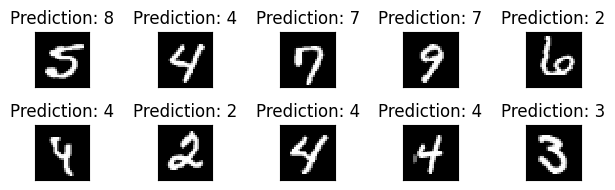

In [11]:
# Run network on data we got before and show predictions
output = model(example_data)

fig = plt.figure()
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()